## Create Images.

Using a class to create images from the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) based on the maximum imagesize given by 'get_largest_dimension.py' of 3264.  I have set my image generators to only keep images of a specified size, picsize.

In [1]:
from dog_images import DogImages

picsize = 100

lst_dogs = ['n02085620-Chihuahua', 
            'n02085782-Japanese_spaniel',
             'n02085936-Maltese_dog',
            'n02086079-Pekinese',
            'n02086240-Shih-Tzu',
            'n02088364-beagle']
dog_images = DogImages(lst_dogs, picsize)
dog_images.generate_img_files()
train_imgs = dog_images.load_images('train')
test_imgs = dog_images.load_images('test')
Xtest = test_imgs[0]
Ytest = test_imgs[1]
Xtrain = train_imgs[0]
Ytrain = train_imgs[1]

In [2]:
import numpy as np
Xhold = Xtrain.copy()
Yhold = Ytrain.copy()
new = np.array([i for i in range(Xhold.shape[0])])
np.random.shuffle(new)
for i, n in enumerate(new):
    Xtrain[i, :] = Xhold[n, :]
    Ytrain[i, :] = Yhold[n, :]
    
Xhold = Xtest
Yhold = Ytest
new = np.array([i for i in range(Xhold.shape[0])])
np.random.shuffle(new)
for i, n in enumerate(new):
    Xtest[i, :] = Xhold[n, :]
    Ytest[i, :] = Yhold[n, :]

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
x = tf.placeholder(tf.float32, shape=[None, picsize*picsize*3], name='X')

# When passing through the network, we want to represent the images
# as a 4-tensor: (n_images, image_height, image_width, n_channels)
x_image = tf.reshape(x, [-1, picsize, picsize, 3], name='ximage')

(1764, 100, 100, 3)


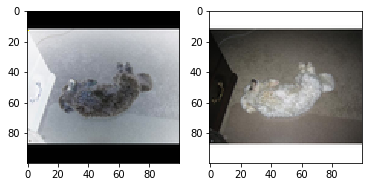

In [5]:
sess = tf.InteractiveSession()
# with tf.Session() as sess:
# Initialize everything and prepare for training.
sess.run(tf.global_variables_initializer())
print(x_image.eval(feed_dict={x:Xtrain}).shape)
img = x_image[0].eval(feed_dict={x:Xtrain})
fig, axes = plt.subplots(1, 2)
ax=list(axes.flatten())
ax[0].imshow(img)
ax[0].grid(False)
ax[1].imshow(Image.fromarray(np.uint8(img)))
ax[1].grid(False)
plt.show()

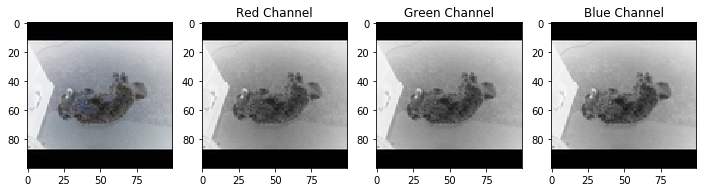

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(12, 8))

axs[0].imshow(img)
axs[0].grid(False)
for i in range(1, 4):
    axs[i].imshow(img[:, :, i-1], cmap=plt.cm.gray_r)
    axs[i].set_title("{} Channel".format(["Red", "Green", "Blue"][i-1]))
plt.show()

In [7]:
print("Total Data Set Shape: {}".format(x_image.eval(feed_dict={x:Xtrain}).shape))

Total Data Set Shape: (1764, 100, 100, 3)


In [8]:
def shuffle_function(X, y):
    Xhold = X.copy()
    Yhold = y.copy()
    new = np.array([i for i in range(Xhold.shape[0])])
    np.random.shuffle(new)
    for i, n in enumerate(new):
        X[i, :] = Xhold[n, :]
        y[i, :] = Yhold[n, :]
    return X, y

## Single layer network...
A fully connected network with no hidden layers

![Fully Connected Network With No Hidden Layers](WebImages\fully_connected.png)

In [9]:
# Placeholder for the input data.
x = tf.placeholder(tf.float32, [None, picsize * picsize * 3])
# Placeholder for input class labels.
y = tf.placeholder(tf.float32, [None, len(lst_dogs)])

# Weights.  There are len(lst_dogs) output classes, and one weight per (pixel, output class)
# combination.
W = tf.Variable(tf.truncated_normal([picsize * picsize * 3, len(lst_dogs)], stddev=0.1), name='W')

# Biasies.  This is like an intercept term in a linear regression.  There is one
# per output class.
b = tf.Variable(tf.truncated_normal([len(lst_dogs)], stddev=0.001), name='b')

# Output layer, probabilities of each class.
y_hat = tf.nn.softmax(tf.matmul(x, W) + b)

# Our loss function.
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat))

# Evaluate the classification accuracy.  What percentage of the test images were
# correctly classified.
prediction = tf.argmax(y_hat, 1)
correct_prediction = tf.equal(prediction, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
# Train the model by gradient descent, for a fixed 1000 iterations.
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(cross_entropy)

tf.global_variables_initializer().run()
slides = int(Xtrain.shape[0]/100)
train_steps = int(Xtrain.shape[0]/slides)
for ep in range(100):
    Xtrain, Ytrain = shuffle_function(Xtrain, Ytrain)
    for step in range(train_steps):
        batch_xs = Xtrain[i*slides:i*slides + slides - 1] 
        batch_ys = Ytrain[i*slides:i*slides + slides - 1]
        sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
    print('\r Percent Complete: {:.2f}% - Accuracy {:.2f}%'.format(100*(ep+1)/100, 
                                                                   accuracy.eval(feed_dict={x: Xtest, y: Ytest})*100), end='')
print()
print("Test Error Accuracy: {:0.2f}%".format(100*sess.run(accuracy, feed_dict={x: Xtest, y: Ytest})))
save_W = W.eval()

 Percent Complete: 100.00% - Accuracy 25.28%
Test Error Accuracy: 25.28%


Not the best.  We need some hidden layers.  But first, I want to see *eigenpuppies*:

In [11]:
from math import sqrt

def plot_digit_weights(ax, image, convert=False): 
    """Plot the weights from our fit fully connected network as an image."""
    size = image.shape[0]
    n = int(sqrt(size/3))
    img = image.reshape(n,n,3)
#     if convert==True:
#         img = Image.fromarray(np.uint8(img))
    ax.imshow(img)

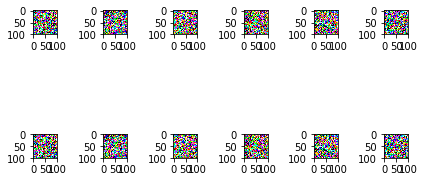

In [12]:

fig, axs = plt.subplots(2, len(lst_dogs))
for n, ax in enumerate(axs.flatten()):
    if n<= len(lst_dogs) - 1:
        plot_digit_weights(ax, save_W[:,n])
    else:
        a = n - len(lst_dogs)
        plot_digit_weights(ax, save_W[:,a], True)
plt.tight_layout()
plt.show()

In [13]:
sess.close()

## Single hidden Layer
Trying with a single hidden layer...

![Single Hidden Layer](WebImages/single_layer.png)

Where N is somenumber of hidden features...

In [14]:

for N in range(len(lst_dogs), len(lst_dogs)*5, len(lst_dogs)):
    # Set-Up
    y = tf.placeholder(tf.float32, [None, len(lst_dogs)])
    # three channels, picsize of picsize
    X = tf.placeholder(tf.float32, [None, picsize*picsize*3])

    # Weights & bias...
    W1 = tf.Variable(tf.truncated_normal([picsize*picsize*3, N], stddev=0.1), name='W1')
    b1 = tf.Variable(tf.truncated_normal([N,], stddev=0.1), name='b1')
    
    # Run it...
    X1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    
    # Weights & bias...
    W2 = tf.Variable(tf.truncated_normal([N, len(lst_dogs)], stddev=0.1), name='W2')
    b2 = tf.Variable(tf.truncated_normal([len(lst_dogs),], stddev=0.1), name='b2')

    # Math
    y_hat = tf.nn.softmax(tf.matmul(X1, W2) + b2)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat))
    loss_function = cross_entropy + 0.001 * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)) 
    prediction = tf.argmax(y_hat, axis=1)
    correct_prediction = tf.equal(prediction, tf.argmax(y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype='float32'))
    
    # Run it...
    LEARNING_RATE = 0.01
    train_minimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss_function)
    print('\r Percent Complete: {:.2f}% - Accuracy {:.2f}% '.format(0.0, 0.0), end='')

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        slides = len(lst_dogs)*2
        num_batches =  Xtrain.shape[0]/slides
        for ep in range(100):
            Xtrain, Ytrain = shuffle_function(Xtrain, Ytrain)
            for step in range(int(num_batches)):
                xbatch = Xtrain[i*slides:i*slides + slides - 1] 
                ybatch = Ytrain[i*slides:i*slides + slides - 1]
                sess.run(train_minimizer, {X : xbatch, y : ybatch})
            y_pred = sess.run(y_hat, {X: Xtest})
            prediction = tf.argmax(y_pred, axis=1)
            correct_prediction = tf.equal(prediction, tf.argmax(Ytest, axis=1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype='float32'))
            print('\r Percent Complete: {:.2f}% - Accuracy {:.2f}%'.format(100*(ep+1)/100, accuracy.eval()*100), end='')
        ans = tf.argmax(Ytest, axis=1).eval()
        pred = prediction.eval()
        print('\r {}'.format(' '*50), end='')
        print('Accuracy for N = {}: {:.2f}%'.format(N, accuracy.eval()*100))
        save_W = W.eval()
sess.close()

                                                   Accuracy for N = 6: 25.28%
                                                   Accuracy for N = 12: 7.92%
                                                   Accuracy for N = 18: 7.92%
                                                   Accuracy for N = 24: 2.26%


## Convoluted Neural Network
Now to create a convoluted neural network.  Setting it up to use variables, so I can reconstruct it as a class (using sklearn methods) and grid search it to find the best parameters for the situation.

![Convolutional Neural Network](WebImages/fully_connected_cnn.png)

In [44]:
from math import sqrt

out_channels = len(lst_dogs)*3*2
out_channels_2 = out_channels*2
hidden_units = int((len(lst_dogs) + out_channels_2)/2)
regularization_strength = 0.25
batch_size = 100
learning_rate = 0.0005
convolution_size = 5
pool_size = 2
epochs = 300
init_factor = 2.0

loss_threshold = 0.0001

In [45]:
# convolutional layer
# third number = channels, so 3
# from https://stackoverflow.com/questions/45521025/the-loss-function-decreases-but-accuracy-on-train-set-does-not-change-in-tensor

# W1 = tf.Variable(tf.truncated_normal(shape=[convolution_size, convolution_size, 3, out_channels], stddev=weight_std), name='W1')
# b1 = tf.Variable(tf.constant(0.0, shape=[out_channels]), name='b1')

initializer = tf.contrib.layers.variance_scaling_initializer(factor=init_factor)
W1 = tf.Variable(initializer([convolution_size, convolution_size, 3, out_channels]))
b1 = tf.Variable(initializer([out_channels]))

# need my x stuff...
# Tensors representing our input dataset and our input labels
x = tf.placeholder(tf.float32, shape=[None, picsize*picsize*3], name='X')
y = tf.placeholder(tf.float32, shape=[None, len(lst_dogs)], name='y')

# When passing through the network, we want to represent the images
# as a 4-tensor: (n_images, image_height, image_width, n_channels)
x_image = tf.reshape(x, [-1, picsize, picsize, 3], name='ximage')

# now the convolution, turns W1/x_m
'''Given an input tensor of shape [batch, in_height, in_width, in_channels] 
and a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]'''
conv1 = tf.nn.conv2d(x_image, W1,
                     strides=[1, 1, 1, 1],
                     padding='SAME', name='conv1')
# [batch, out_height, out_width, filter_height * filter_width * in_channels]
# so [?, out_height, out_width, 75]
relu1 = tf.nn.relu(conv1 + b1)  # shape [?, picsize, picsize, out_channels]

In [46]:
# Step 2: a 2x2 Max Pool 'Layer'
# ksize is the size of the windows to overlay.
# strides controls how to slide the windows around the image.
layer_1_out = tf.nn.max_pool(relu1,
                             ksize=[1, pool_size, pool_size, 1],
                             strides=[1, pool_size, pool_size, 1],
                             padding='SAME')
# size = [?, picsize/2, picsize/2, out_channles]

In [47]:

# convolutional layer  2
# weight_std = sqrt(2/((picsize/2)*(picsize/2)*out_channels))
# W2 = tf.Variable(tf.truncated_normal(shape=[convolution_size, convolution_size, out_channels, out_channels_2], stddev=weight_std), name='w2')
# b2 = tf.Variable(tf.constant(0.0, shape=[out_channels_2]))


W2 = tf.Variable(initializer([convolution_size, convolution_size, out_channels, out_channels_2]))
b2 = tf.Variable(initializer([out_channels_2]))


# now the convolution... on layer_1_out
conv2 = tf.nn.conv2d(layer_1_out, W2,
                     strides=[1, 1, 1, 1],
                     padding='SAME', name='conv2')
relu2 = tf.nn.relu(conv2 + b2)
# size of both above: (?, picsize/2, picsize/2, out_channels_2)

layer_2_out = tf.nn.max_pool(relu2,
                         ksize=[1, pool_size, pool_size, 1],
                         strides=[1, pool_size, pool_size, 1],
                         padding='SAME')
# size of both above: (?, picsize/4, picsize/4, out_channels_2)

In [48]:
# A fully connected layer, this time with 512 hidden units (coming from 38x38x48 inputs). 
# Use ReLU activation.
# weight_std = sqrt(2/int(picsize**2 * 1/16 * out_channels_2))
# Wf = tf.Variable(tf.truncated_normal(shape=[int(picsize**2 * 1/16 * out_channels_2), hidden_units], stddev=weight_std))

# bf = tf.Variable(tf.constant(0.0, shape=[hidden_units]))

Wf = tf.Variable(initializer([int(picsize**2 * 1/16 * out_channels_2), hidden_units]))
bf = tf.Variable(initializer([hidden_units]))


# Flatten the output of the second layer.  This allows us to do
# a simple matrix multiplication with the weight matrix for the
# fully connected layer.
layer_2_out_flat = tf.reshape(layer_2_out, [-1, int(picsize**2 * 1/16 * out_channels_2)])

fully_connected_1_out = tf.nn.relu(tf.matmul(layer_2_out_flat, Wf) + bf)
# size: ?, hidden_units

In [49]:
# weight_std = sqrt(2/hidden_units)
# Wf2 = tf.Variable(tf.truncated_normal(shape=[hidden_units, len(lst_dogs)], stddev=weight_std))
# bf2 = tf.Variable(tf.constant(0.0, shape=[len(lst_dogs)]))


Wf2 = tf.Variable(initializer([hidden_units, len(lst_dogs)]))
bf2 = tf.Variable(initializer([len(lst_dogs)]))

# The output layer
# Predictions, but on a log-odds scale.
fully_connected_2_out = tf.matmul(fully_connected_1_out, Wf2) + bf2
# shape: inputs, # classes

In [50]:
#Training & Loss Function

# The basic loss function, cross entropy.
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=fully_connected_2_out))

# Use L2 regularization on all the weights in the network.

regularization_term = regularization_strength * (
    tf.nn.l2_loss(W1) +
    tf.nn.l2_loss(W2) +
    tf.nn.l2_loss(Wf) +
    tf.nn.l2_loss(Wf2) 
)

# The total loss function we will minimize is cross entropy
# plus regularization.
total_loss = cross_entropy + regularization_term

In [51]:
import math

# Training...
# ADAM is a sophisticated version of gradient descent that adapts the
# learning rate over time.
train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
# train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(total_loss)
# Create a tensor to track the accuracy during training.
correct_prediction = tf.equal(tf.argmax(fully_connected_2_out, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [52]:
# One line per 'box' to see why Kernel keeps dying...
sess = tf.InteractiveSession()
# with tf.Session() as sess:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [53]:
import time

# Initialize everything and prepare for training.
start = time.clock()
sess.run(tf.global_variables_initializer())
print('this ran for {:.2f} s'.format(time.clock()-start))

this ran for 1.29 s


In [54]:
# Run the gradient descent, printing out the training and
# testing accuracy every 100 iterations.
train_accuracies, test_accuracies, epoch_accuracies, test_x = [], [], [], []
training_steps = int((Xtrain.shape[0])/batch_size)
print('{} Slides per step for {} training steps per epoch'.format(batch_size, training_steps))

100 Slides per step for 17 training steps per epoch


In [56]:
calc = 0
train_accuracies, test_accuracies, epoch_accuracies, test_x = [], [], [], []
loss_lst = []
j = 0
loss = -9000
diff = loss
old = loss
while j <= epochs and abs(diff) > loss_threshold:
    old = loss
    train_accuracies = []   
    # add a shuffle here!!!!!
    Xhold = Xtrain.copy()
    Yhold = Ytrain.copy()
    new = np.array([i for i in range(Xhold.shape[0])])
    np.random.shuffle(new)
    for i, n in enumerate(new):
        Xtrain[i, :] = Xhold[n, :]
        Ytrain[i, :] = Yhold[n, :]
    for i in range(training_steps):
        if i*batch_size + batch_size - 1 <= Xtrain.shape[0]:
            xbatch = Xtrain[i*batch_size:i*batch_size + batch_size - 1] 
            ybatch = Ytrain[i*batch_size:i*batch_size + batch_size - 1]
            train_step.run(feed_dict={x: xbatch, y: ybatch})
            train_accuracy = accuracy.eval(feed_dict={x:xbatch, y: ybatch})
            train_accuracies.append(train_accuracy)
            loss = total_loss.eval(feed_dict={x: xbatch, y: ybatch})
            calc = 100.0*float((i+1 +j*training_steps)/(training_steps*epochs))
        if len(epoch_accuracies) > 0:
            print('\rPercent Complete: {:.2f}% - Train Accuracy: {:.2f}%, Loss {}'.format(calc, 
                                                                       100*train_accuracies[-1],
                                                                       loss), end='')
        else:
            print('\rPercent Complete: {:.2f}%'.format(calc), end='')
    epoch_accuracies.append(np.mean(train_accuracies))
    if j % 10 == 0:   
        test_accuracy = accuracy.eval(feed_dict={x:Xtest, y: Ytest})
        test_accuracies.append(test_accuracy)
        test_x.append(j)
    loss_lst.append(loss)
    diff = old - loss
    j+=1

print()
test_accuracy = accuracy.eval(feed_dict={x:Xtest, y: Ytest})
test_accuracies.append(test_accuracy)
test_x.append(len(epoch_accuracies))
# loss_lst.append(loss)
loss_lst = loss_lst/np.max(loss_lst)
print('Accuracy = {:.1f}%'.format(100*test_accuracy))

Percent Complete: 3.41% - Train Accuracy: 97.98%, Loss 4.72635555267334835

KeyboardInterrupt: 

In [ ]:
plt.plot(test_x, test_accuracies, label='Test Accuracy')
plt.plot(list(range(len(epoch_accuracies))), epoch_accuracies, label='Train Accuracy')
plt.plot(list(range(len(epoch_accuracies))), np.ones(len(epoch_accuracies))*1/len(lst_dogs), label='Chance')
plt.plot(list(range(len(epoch_accuracies))), loss_lst, label='Loss %')
plt.legend()
plt.show()

In [ ]:
sess.close()
sess.close()

In [66]:
from image_classifier import ImageClassifier


model = ImageClassifier()

NameError: name 'slides' is not defined

In [62]:
from image_classifier import ImageClassifier

for i in range(5):
    model = ImageClassifier(picsize, lst_dogs,
                             out_channels = 24,
                             out_channels_2 = 48,
                             hidden_units = 100,
                             regularization_strength = 0.01,
                             batch_size = 64,
                             learning_rate = 0.1,
                             convolution_size = 5,
                             pool_size = 2,
                             epochs = 50,
                             verbose=True)
    print()
    model.fit(Xtrain, Ytrain)
    lst_y.append(model.score(Xtest, Ytest))
    
plt.plot(lst, lst_y)
plt.xlabel('Hidden Units')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Hidden Units')
plt.show()

model.score(Xtest, Ytest)

NameError: name 'slides' is not defined

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from image_classifier import ImageClassifier
from sklearn.model_selection import GridSearchCV

params = {'picsize':[picsize],
          'classes':[lst_dogs],
          'runs':[25],
          'hidden_units':[int(np.mean((picsize**2 * 1/16 * 48) + len(lst_dogs)))],
          'slides':[len(lst_dogs)*(4 + 2*a) for a in range(6)],
          'verbose':[True]}

gs = GridSearchCV(ImageClassifier(), params)
gs.fit(Xtrain, Ytrain)
print()
print('Best Accuracy: {:.3f}'.format(gs.best_score_))
print('Best Params: {}'.format(gs.best_params_))